In [1]:
import numpy as np
import pandas as pd
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

# 11.1. Queries, Keys, and Values

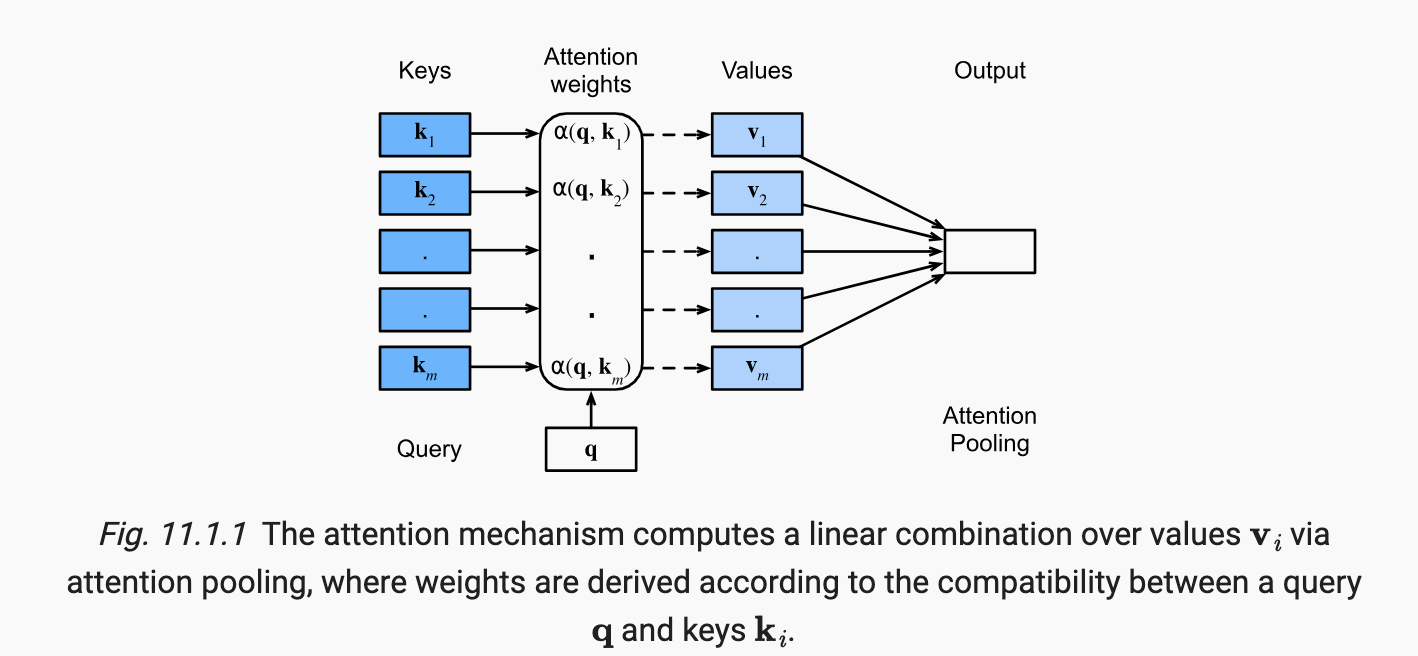

In [2]:
# @save
def show_heatmaps(
    matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"
):
    """
    Show heatmaps of matrices.
    - matrices has the shape (number of rows for display, number of columns for display, number of queries, number of keys)
    """
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(
        num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

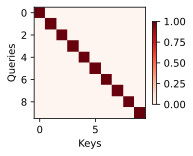

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel="Keys", ylabel="Queries")

# 11.2. Attention Pooling by Similarity

## 11.2.1. Kernels and Data

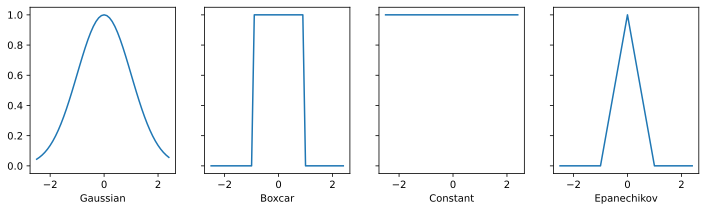

In [4]:
# Define some kernels, all kernels are translation and rotation invariant
def gaussian(x):
    return torch.exp(-(x**2) / 2)


def boxcar(x):
    return torch.abs(x) < 1.0


def constant(x):
    return 1.0 + 0 * x


def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))


fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ("Gaussian", "Boxcar", "Constant", "Epanechikov")
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

In [5]:
# define some training data
def f(x):
    return 2 * torch.sin(x) + x


n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

## 11.2.2. Attention Pooling via Nadaraya–Watson Regression

Let each validation feature be a query, and each training feature–label pair be a key–value pair. As a result, the normalized relative kernel weights (attention_w below) are the attention weights.

In [6]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train @ attention_w
    return y_hat, attention_w

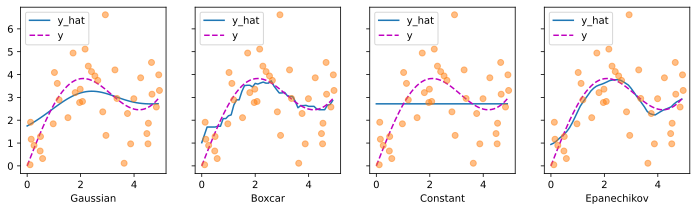

In [7]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap="Reds")
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, "m--")
            ax.plot(x_train, y_train, "o", alpha=0.5)
        ax.set_xlabel(name)
        if not attention:
            ax.legend(["y_hat", "y"])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)


plot(x_train, y_train, x_val, y_val, kernels, names)

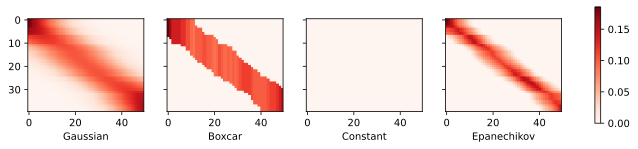

In [8]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The visualization clearly shows why the estimates for Gaussian, Boxcar, and Epanechikov are very similar: after all, they are derived from very similar attention weights, despite the different functional form of the kernel.

## 11.2.3. Adapting Attention Pooling

replace the Gaussian kernel with one of a different width. That is, we could use $\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$ where $\sigma^2$ determines the width of the kernel

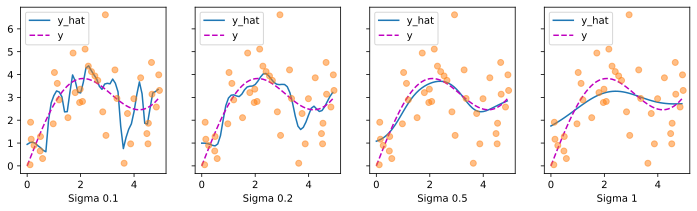

In [9]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ["Sigma " + str(sigma) for sigma in sigmas]


def gaussian_with_width(sigma):
    return lambda x: torch.exp(-(x**2) / (2 * sigma**2))


kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

the narrower the kernel, the less smooth the estimate. At the same time, it adapts better to the local variations

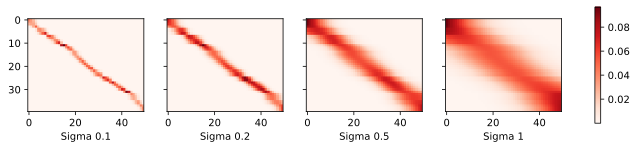

In [10]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

the narrower the kernel, the narrower the range of large attention weights.

# 11.3. Attention Scoring Functions

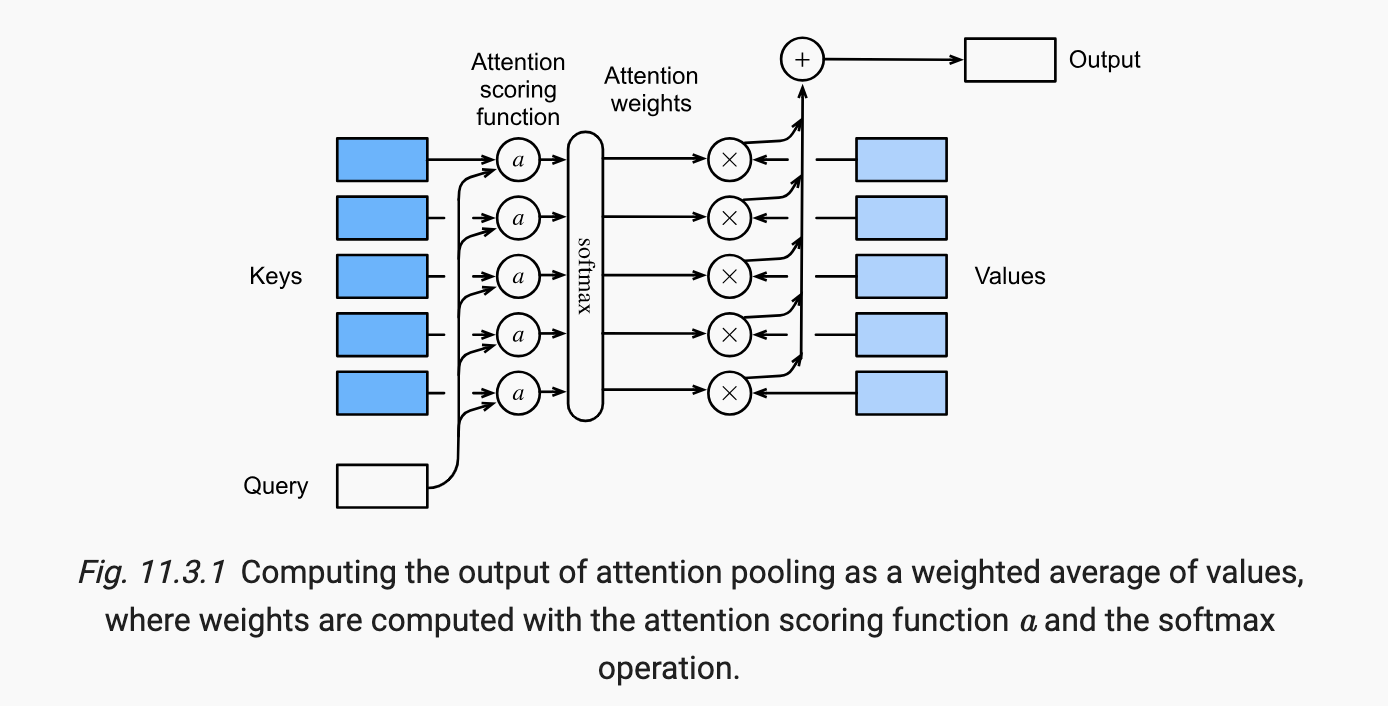

## 11.3.2. Convenience Functions

In [11]:
def masked_softmax(X, valid_lens):  # @save
    """Perform softmax operation by masking elements on the last axis."""

    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = (
            torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :]
            < valid_len[:, None]
        )
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [12]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5361, 0.4639, 0.0000, 0.0000],
         [0.6360, 0.3640, 0.0000, 0.0000]],

        [[0.4472, 0.3717, 0.1811, 0.0000],
         [0.4473, 0.3637, 0.1891, 0.0000]]])

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2992, 0.3573, 0.3435, 0.0000]],

        [[0.4025, 0.5975, 0.0000, 0.0000],
         [0.2141, 0.2564, 0.1991, 0.3304]]])

batch matrix multiplication (BMM)
$$\begin{split}\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.\end{split}$$
$$\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$

In [14]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

## 11.3.3. Scaled Dot Product Attention

The scaled dot product attention of queries $\mathbf Q\in\mathbb R^{n\times d}$, keys $\mathbf K\in\mathbb R^{m\times d}$, and values $\mathbf V\in\mathbb R^{m\times v}$ thus can be written as
$$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

In [15]:
class DotProductAttention(nn.Module):  # @save
    """Scaled dot product attention."""

    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

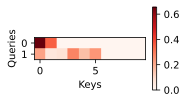

In [17]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries"
)

the attention weights actually vanish for anything beyond the second and sixth column respectively

## 11.3.4. Additive Attention

Given a query $\mathbf{q} \in \mathbb{R}^q$ and a key $\mathbf{k} \in \mathbb{R}^k$, the additive attention scoring function is given by
$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters

In [18]:
class AdditiveAttention(nn.Module):  # @save
    """Additive attention."""

    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [19]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

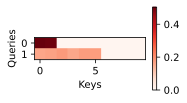

In [20]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries"
)

# 11.4. The Bahdanau Attention Mechanism

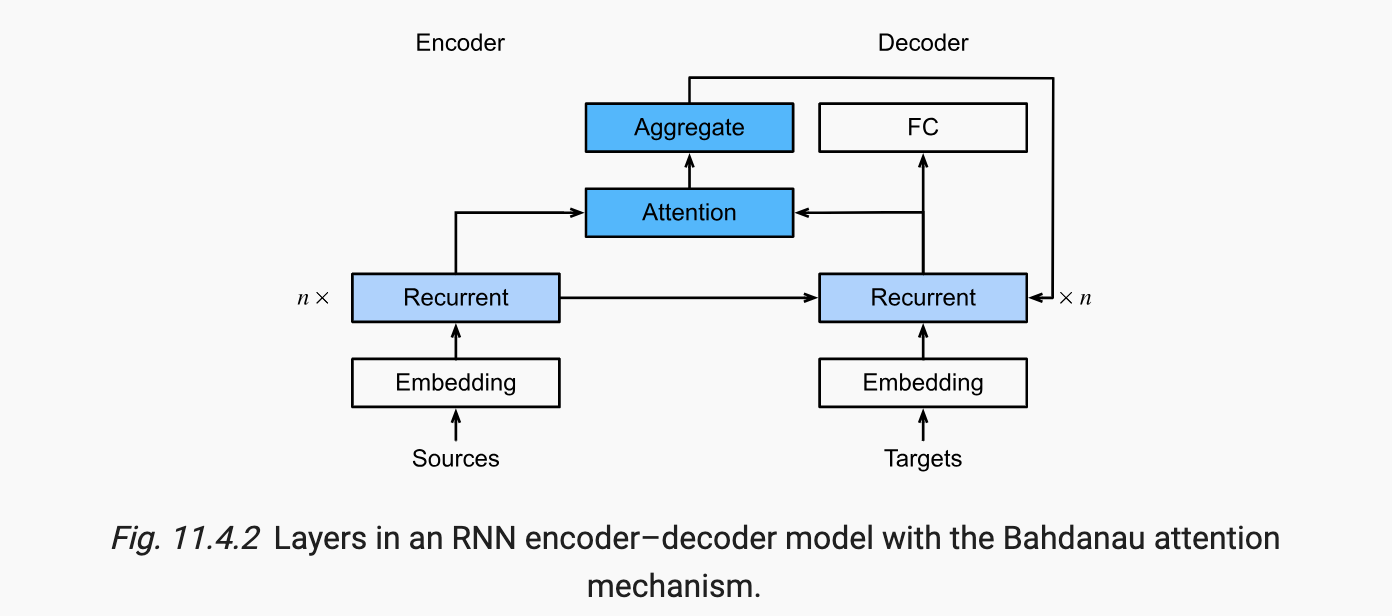

The state of the decoder is initialized with
- the hidden states of the last layer of the encoder at all time steps, used as keys and values for attention
- the hidden state of the encoder at all layers at the final time step, which serves to initialize the hidden state of the decoder
- the valid length of the encoder, to exclude the padding tokens in attention pooling
- At each decoding time step, the hidden state of the final layer of the decoder, obtained at the previous time step, is used as the query of the attention mechanism
- Both the output of the attention mechanism and the input embedding are concatenated to serve as the input of the RNN decoder.

## 11.4.2. Defining the Decoder with Attention

In [21]:
class AttentionDecoder(d2l.Decoder):  # @save
    """The base attention-based decoder interface."""

    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [22]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout
        )
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [23]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

## 11.4.3. Training

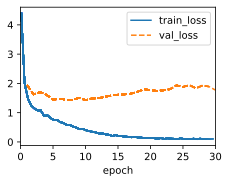

In [24]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout
)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout
)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab["<pad>"], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [25]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == "<eos>":
            break
        translation.append(token)
    print(
        f"{en} => {translation}, bleu,"
        f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}'
    )

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['soyez', 'calmes', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


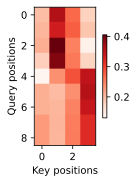

In [26]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True
)
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, : len(engs[-1].split()) + 1].cpu(),
    xlabel="Key positions",
    ylabel="Query positions",
)

# 11.5. Multi-Head Attention

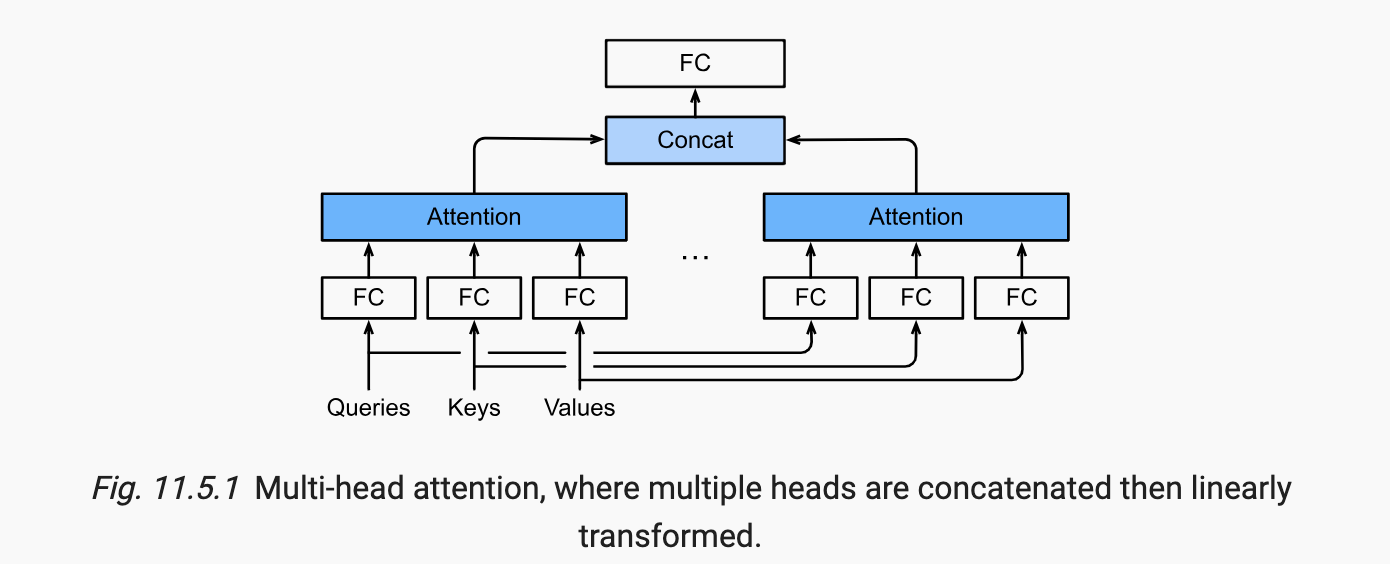

In [27]:
class MultiHeadAttention(d2l.Module):  # @save
    """Multi-head attention."""

    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [28]:
@d2l.add_to_class(MultiHeadAttention)  # @save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


@d2l.add_to_class(MultiHeadAttention)  # @save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(
        X.shape[0], X.shape[1], -1
    )  # (batch_size, num_queries, num_hiddens)

In [29]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens), (batch_size, num_queries, num_hiddens))

# 11.6. Self-Attention and Positional Encoding

Given a sequence of input tokens $\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^d$ ($1 \leq i \leq n$), its self-attention outputs a sequence of the same length $\mathbf{y}_1, \ldots, \mathbf{y}_n$, where

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$

## 11.6.1. Self-Attention

In [30]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens), (batch_size, num_queries, num_hiddens))

## 11.6.2. Comparing CNNs, RNNs, and Self-Attention

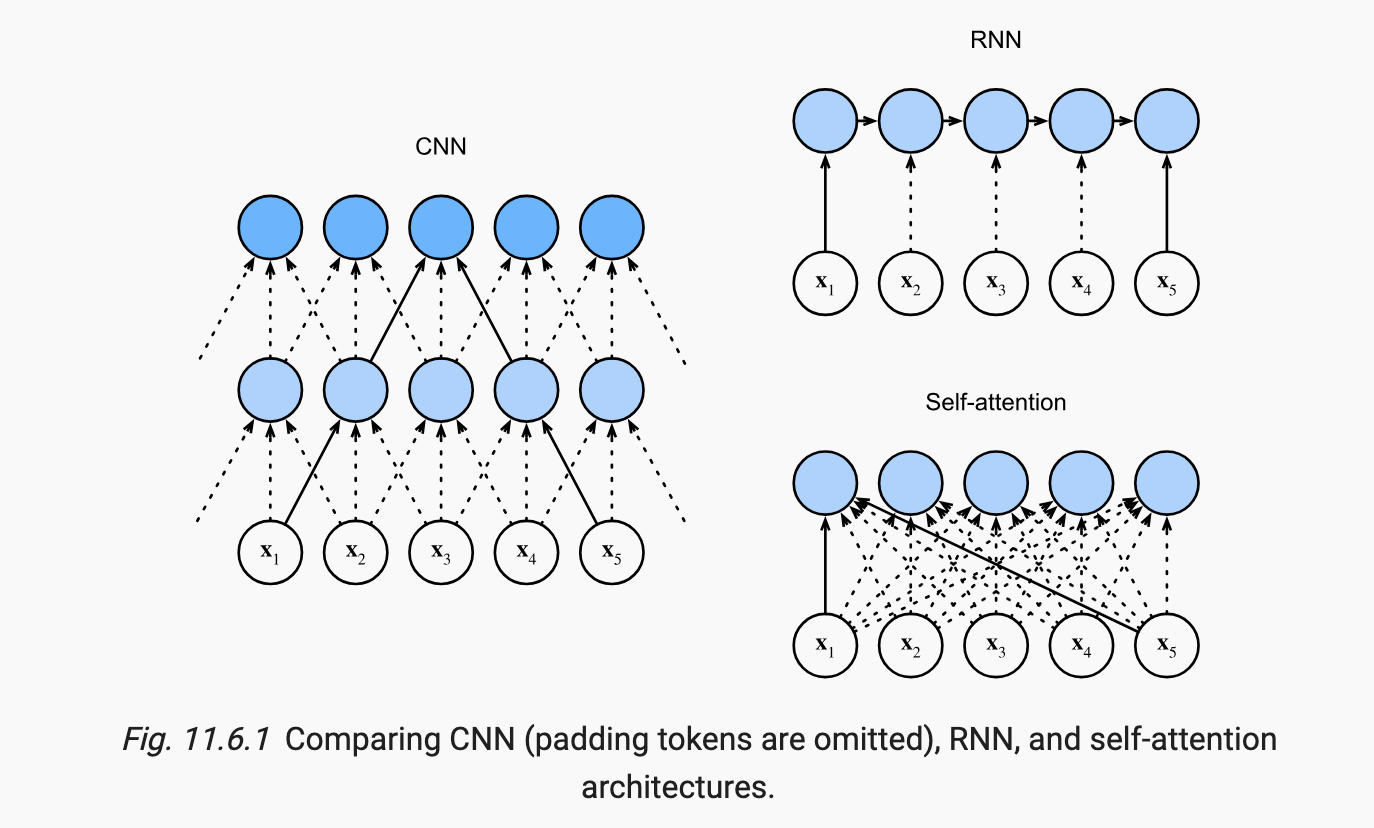

- both CNNs and self-attention enjoy parallel computation and self-attention has the shortest maximum path length
- However, the quadratic computational complexity with respect to the sequence length makes self-attention prohibitively slow for very long sequences.

## 11.6.3. Positional Encoding

self-attention by itself does not preserve the order of the sequence

In [31]:
class PositionalEncoding(nn.Module):  # @save
    """Positional encoding."""

    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens
        )
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, : X.shape[1], :].to(X.device)
        return self.dropout(X)

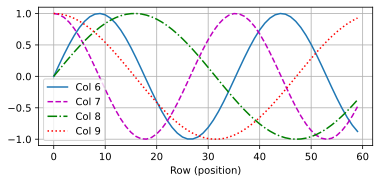

In [32]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, : X.shape[1], :]
d2l.plot(
    torch.arange(num_steps),
    P[0, :, 6:10].T,
    xlabel="Row (position)",
    figsize=(6, 2.5),
    legend=["Col %d" % d for d in torch.arange(6, 10)],
)

In [33]:
for i in range(8):
    print(f"{i} in binary is {i:>03b}")

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


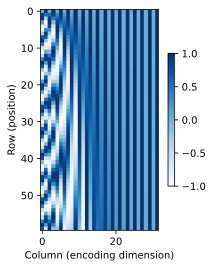

In [34]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(
    P,
    xlabel="Column (encoding dimension)",
    ylabel="Row (position)",
    figsize=(3.5, 4),
    cmap="Blues",
)

# 11.7. The Transformer Architecture

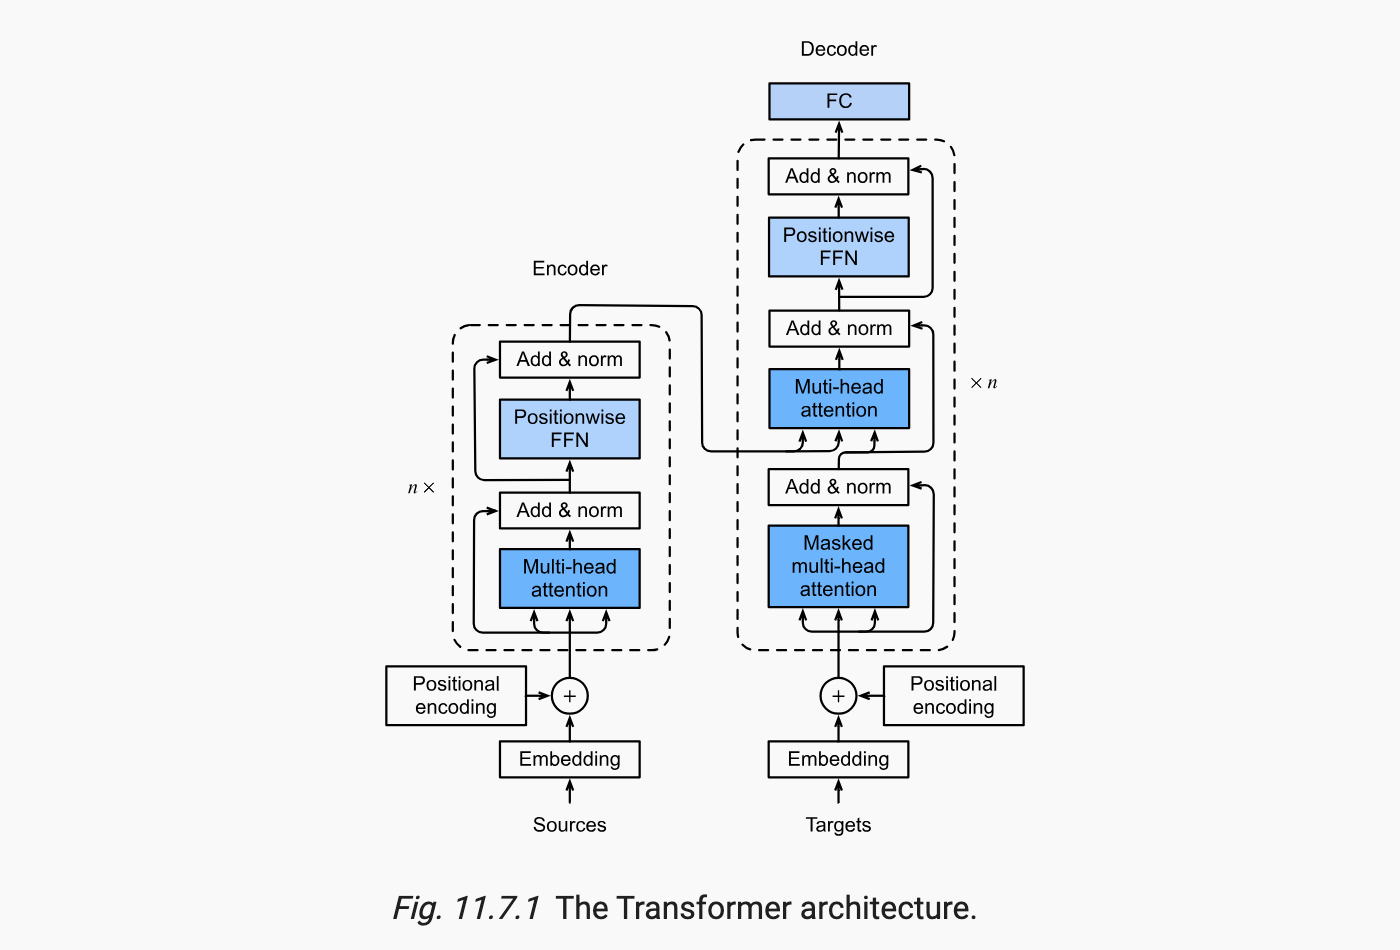

## 11.7.2. Positionwise Feed-Forward Networks

In [35]:
class PositionWiseFFN(nn.Module):  # @save
    """The positionwise feed-forward network."""

    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(
        self, X
    ):  # X: (batch_size, num_steps or len_tokens, num_hiddens or feature_size)
        return self.dense2(
            self.relu(self.dense1(X))
        )  # (batch size, number of time steps, ffn_num_outputs)

In [36]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.6445, -0.5972,  0.1166,  0.1399,  0.1159,  0.3751,  0.0190,  0.2846],
        [-0.6445, -0.5972,  0.1166,  0.1399,  0.1159,  0.3751,  0.0190,  0.2846],
        [-0.6445, -0.5972,  0.1166,  0.1399,  0.1159,  0.3751,  0.0190,  0.2846]],
       grad_fn=<SelectBackward0>)

## 11.7.3. Residual Connection and Layer Normalization

In [37]:
# compares the normalization across different dimensions by layer normalization and batch normalization
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print("layer norm:", ln(X), "\nbatch norm:", bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [38]:
class AddNorm(nn.Module):  # @save
    """The residual connection followed by layer normalization."""

    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [39]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

## 11.7.4. Encoder

TransformerEncoderBlock class contains two sublayers: multi-head self-attention and positionwise feed-forward networks, where a residual connection followed by layer normalization is employed around both sublayers

In [40]:
class TransformerEncoderBlock(nn.Module):  # @save
    """The Transformer encoder block."""

    def __init__(
        self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False
    ):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias
        )
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [41]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In [42]:
class TransformerEncoder(d2l.Encoder):  # @save
    """The Transformer encoder."""

    def __init__(
        self,
        vocab_size,
        num_hiddens,
        ffn_num_hiddens,
        num_heads,
        num_blks,
        dropout,
        use_bias=False,
    ):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                "block" + str(i),
                TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias
                ),
            )

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [43]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
d2l.check_shape(
    encoder(torch.ones((2, 100), dtype=torch.long), valid_lens), (2, 100, 24)
)

## 11.7.5. Decoder

 TransformerDecoderBlock class, which contains three sublayers: decoder self-attention, encoder–decoder attention, and positionwise feed-forward networks. These sublayers employ a residual connection around them followed by layer normalization.

In [44]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(
                batch_size, 1
            )
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [45]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

In [46]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(
        self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout
    ):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                "block" + str(i),
                TransformerDecoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, i
                ),
            )
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 11.7.6. Training

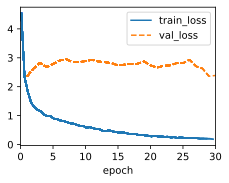

In [47]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout
)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout
)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab["<pad>"], lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [48]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == "<eos>":
            break
        translation.append(token)
    print(
        f"{en} => {translation}, bleu,"
        f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}'
    )

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [49]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True
)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(
    enc_attention_weights, (num_blks, num_heads, data.num_steps, data.num_steps)
)

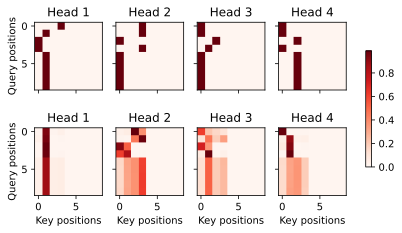

In [50]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(),
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)

 Each head independently attends based on a separate representation subspace of queries, keys, and values.

In [51]:
dec_attention_weights_2d = [
    head[0].tolist()
    for step in dec_attention_weights
    for attn in step
    for blk in attn
    for head in blk
]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values
)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(
    1, 2, 3, 0, 4
)

d2l.check_shape(
    dec_self_attention_weights, (num_blks, num_heads, data.num_steps, data.num_steps)
)
d2l.check_shape(
    dec_inter_attention_weights, (num_blks, num_heads, data.num_steps, data.num_steps)
)

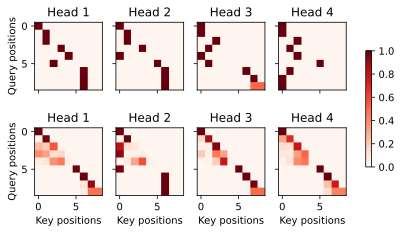

In [52]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)

Because of the autoregressive property of the decoder self-attention, no query attends to key–value pairs after the query position.

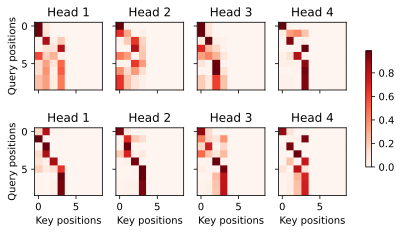

In [53]:
d2l.show_heatmaps(
    dec_inter_attention_weights,
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)

Similar to the case in the encoder self-attention, via the specified valid length of the input sequence, no query from the output sequence attends to those padding tokens from the input sequence.



# 11.8. Transformers for Vision

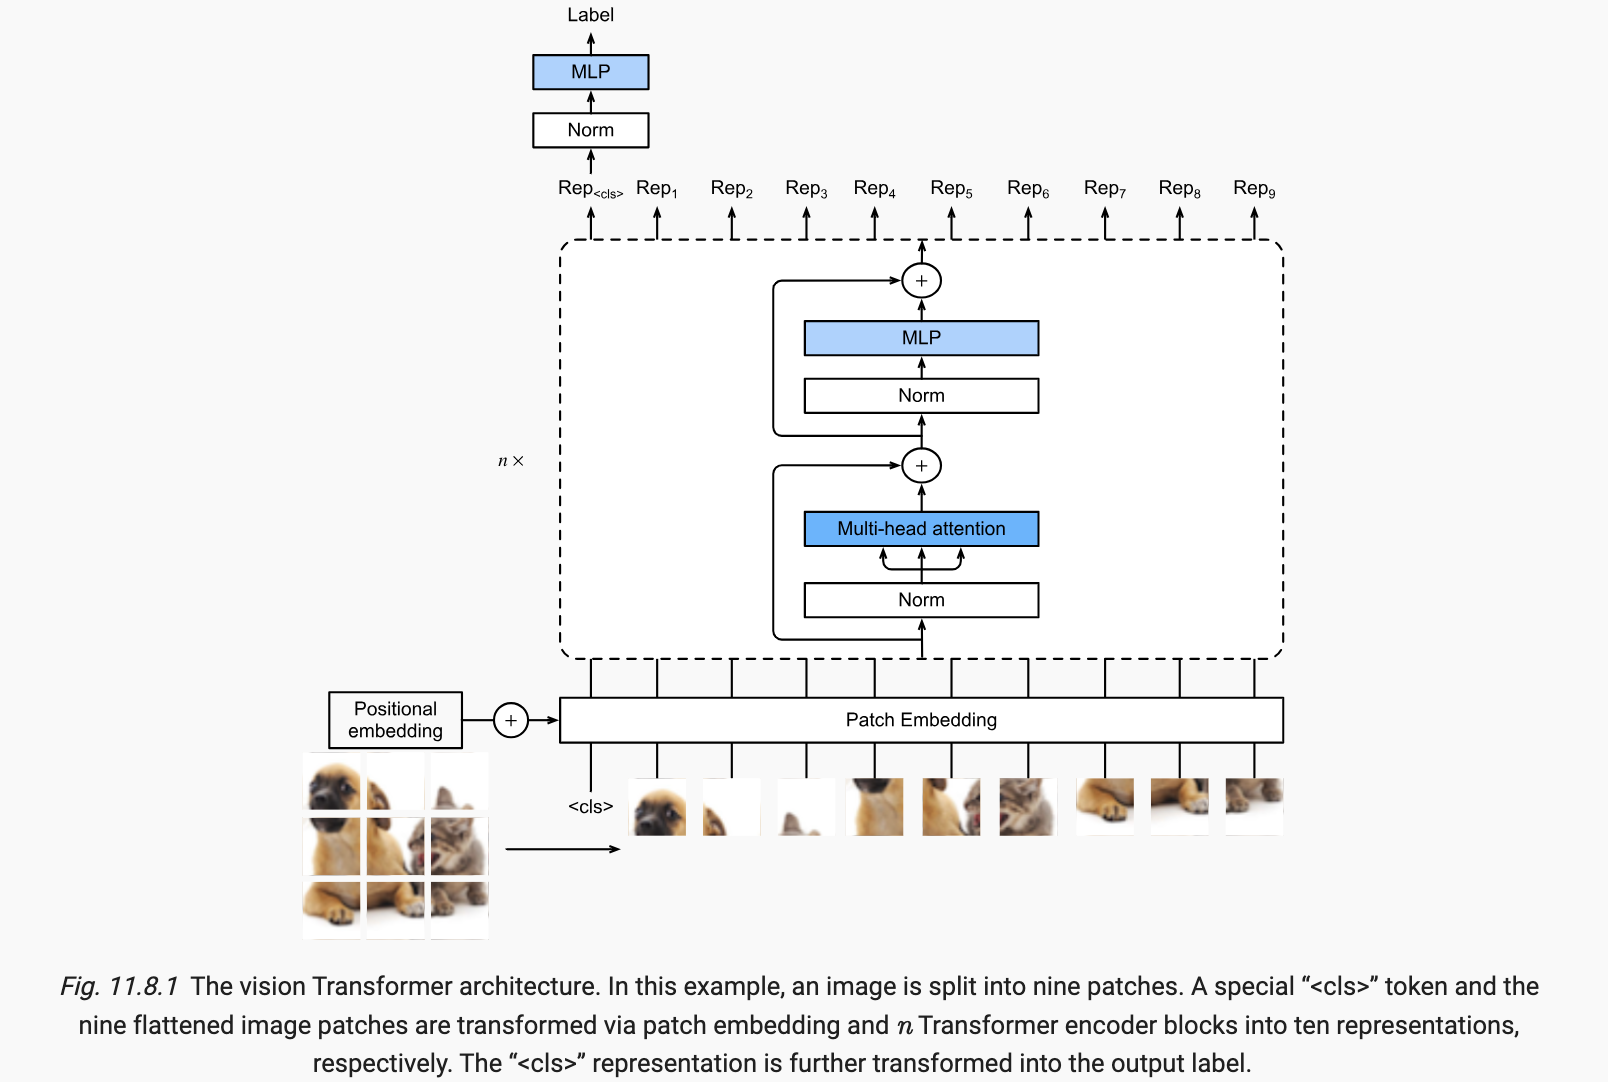

## 11.8.2. Patch Embedding

In [54]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()

        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x

        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1]
        )
        self.conv = nn.LazyConv2d(
            num_hiddens, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [55]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X), (batch_size, (img_size // patch_size) ** 2, num_hiddens))

## 11.8.3. Vision Transformer Encoder

In [56]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(x)))))

In [57]:
class ViTBlock(nn.Module):
    def __init__(
        self,
        num_hiddens,
        norm_shape,
        mlp_num_hiddens,
        num_heads,
        dropout,
        use_bias=False,
    ):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias
        )
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [58]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)

## 11.8.4. Putting It All Together

In [59]:
class ViT(d2l.Classifier):
    """Vision Transformer."""

    def __init__(
        self,
        img_size,
        patch_size,
        num_hiddens,
        mlp_num_hiddens,
        num_heads,
        num_blks,
        emb_dropout,
        blk_dropout,
        lr=0.1,
        use_bias=False,
        num_classes=10,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                f"{i}",
                ViTBlock(
                    num_hiddens,
                    num_hiddens,
                    mlp_num_hiddens,
                    num_heads,
                    blk_dropout,
                    use_bias,
                ),
            )
        self.head = nn.Sequential(
            nn.LayerNorm(num_hiddens), nn.Linear(num_hiddens, num_classes)
        )

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

## 11.8.5. Training

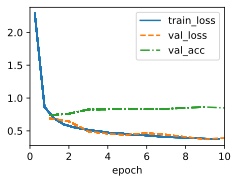

In [60]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(
    img_size,
    patch_size,
    num_hiddens,
    mlp_num_hiddens,
    num_heads,
    num_blks,
    emb_dropout,
    blk_dropout,
    lr,
)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

# 11.9. Large-Scale Pretraining with Transformers